In [174]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
%matplotlib inline
from matplotlib import pyplot as plt

In [176]:
import sys
import os
from subprocess import call 
import pathlib

In [177]:
from datetime import datetime

In [178]:
from datetime import datetime, timedelta

In [179]:
import numpy as np
import pandas as pd
import xarray as xr

In [180]:
sys.path.append('../code/')

In [181]:
import src

In [182]:
regions = ['NZ','Ninos','IOD']

In [183]:
region = 'NZ'

In [184]:
dpath = pathlib.Path('/media/nicolasf/END19101/data/OISST/daily/').joinpath(region)

In [185]:
clim_path = pathlib.Path(f'../outputs/{region}')

In [186]:
current_date = datetime.utcnow()

In [187]:
ndays_agg = 30

In [188]:
ndays_back = 90 

In [189]:
first_day = current_date - timedelta(days=ndays_back)

In [190]:
years_to_get = np.unique(np.arange(first_day.year, current_date.year + 1))

In [191]:
l_dset = []

for year in years_to_get: 
    
    dset = xr.open_dataset(dpath.joinpath(f'sst.day.mean.{year}.v2.nc')) 
    
    l_dset.append(dset)

In [192]:
dset = xr.concat(l_dset, dim='time')

In [193]:
dset

<xarray.Dataset>
Dimensions:  (time: 219, lat: 80, lon: 72)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-08-07
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon      (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
Data variables:
    sst      (time, lat, lon) float32 10.34 10.25 10.22 ... 20.11 19.93 19.87

In [194]:
dset = dset.convert_calendar('noleap')

In [195]:
clim = xr.open_zarr(clim_path.joinpath(f'{region}_OISST_{ndays_agg}days_climatology_15_window.zarr'))

In [196]:
anoms = dset.groupby(dset.time.dt.dayofyear) - clim['average']

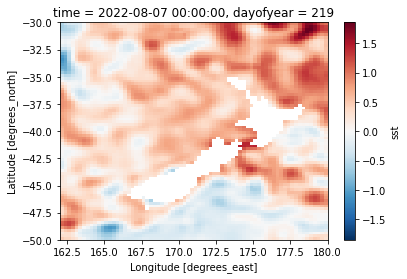

In [197]:
anoms.isel(time=-1)['sst'].plot()

In [198]:
anoms

<xarray.Dataset>
Dimensions:    (time: 219, lat: 80, lon: 72)
Coordinates:
  * time       (time) object 2022-01-01 00:00:00 ... 2022-08-07 00:00:00
  * lat        (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon        (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 212 213 214 215 216 217 218 219
Data variables:
    sst        (time, lat, lon) float64 dask.array<chunksize=(183, 20, 18), meta=np.ndarray>

In [199]:
clim_repeat = clim.sel(dayofyear=dset.time.dt.dayofyear)

In [200]:
clim_repeat

<xarray.Dataset>
Dimensions:    (lat: 80, lon: 72, time: 219, quantile: 5)
Coordinates:
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 212 213 214 215 216 217 218 219
  * lat        (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon        (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
  * quantile   (quantile) float64 0.1 0.25 0.5 0.75 0.9
  * time       (time) object 2022-01-01 00:00:00 ... 2022-08-07 00:00:00
Data variables:
    average    (lat, lon, time) float64 dask.array<chunksize=(20, 18, 183), meta=np.ndarray>
    quantiles  (time, quantile, lat, lon) float64 dask.array<chunksize=(92, 2, 20, 36), meta=np.ndarray>
    std        (lat, lon, time) float64 dask.array<chunksize=(20, 18, 183), meta=np.ndarray>

In [201]:
mask = dset['sst'].where(dset['sst'] >= clim_repeat['quantiles'].sel(quantile=0.9))

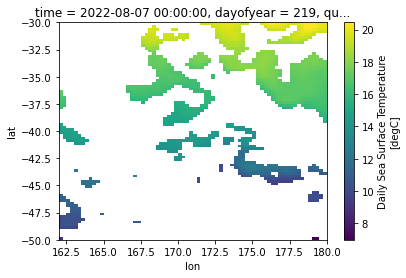

In [202]:
mask[-1,:,:].plot()

In [203]:
mask = mask.where(np.isnan(mask), other=1)[-1,:,:]

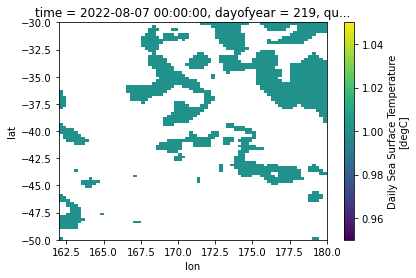

In [204]:
mask.plot()

In [205]:
data_to_map = anoms.isel(time=-1)['sst']

In [206]:
data_to_map_interp = src.interpolate_NaN_da(data_to_map)

In [207]:
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [208]:
states_provinces = cfeature.NaturalEarthFeature(
category='cultural',
name='admin_1_states_provinces_lines',
scale='10m',
facecolor='none')

lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '10m')
rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m')
land = cfeature.NaturalEarthFeature('physical', 'land', '10m')

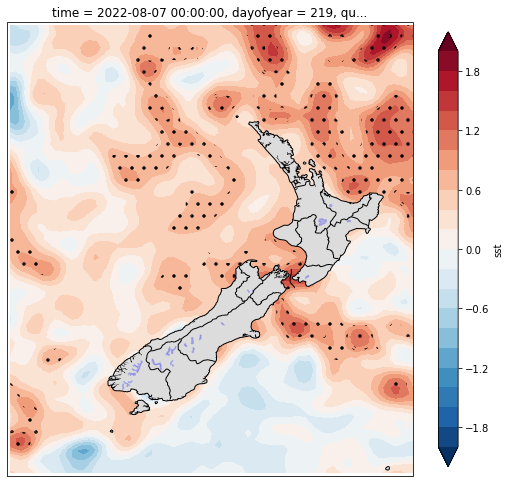

In [209]:
fig = plt.figure(figsize=(20, 20))

# SST anomaly
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([162, 179.9, -50, -30])

ax1.coastlines('10m', linewidth=2)
ax1.add_feature(land, facecolor='gainsboro')
ax1.add_feature(lakes, facecolor='b', edgecolor='b',  alpha = 0.2)
ax1.add_feature(states_provinces, edgecolor='k', linewidth=1)


data_to_map_interp.plot.contourf(ax=ax1, levels=20, transform=ccrs.PlateCarree(), extend='both', cbar_kwargs={'shrink':0.4})

# (data_to_map_interp * mask).plot.contourf(ax=ax1, levels=20, transform=ccrs.PlateCarree())

(data_to_map_interp * mask).plot.contourf(ax=ax1, levels=20, transform=ccrs.PlateCarree(), colors='none', hatches=[None, '.', '.', '.', '.', '.'], add_colorbar=False)

### calculates the regional averages 

In [21]:
dset = src.calculates_ninos(dset, nino='all')

In [22]:
if ndays_agg is not None: 
    
    dset['sst'] = dset['sst'].rolling({'time':ndays_agg}, center=False, min_periods=ndays_agg).mean('time')
    
    dset = dset.isel(time=slice(ndays_agg+1,None))

In [23]:
dset

<xarray.Dataset>
Dimensions:  (nino: 5, time: 217)
Coordinates:
  * nino     (nino) object '1+2' '3' '4' '3.4' 'oni'
  * time     (time) datetime64[ns] 2022-01-03 2022-01-04 ... 2022-08-07
Data variables:
    sst      (nino, time) float32 22.87 22.96 23.05 23.18 ... 25.94 25.91 25.89

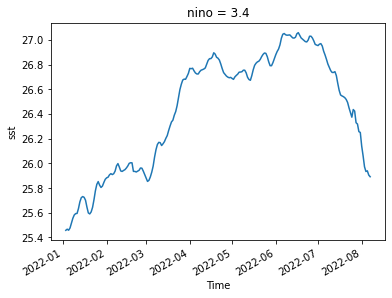

In [24]:
dset.sel(nino='3.4')['sst'].plot()

In [25]:
dset = dset.convert_calendar('noleap')

In [26]:
dset

<xarray.Dataset>
Dimensions:  (nino: 5, time: 217)
Coordinates:
  * nino     (nino) object '1+2' '3' '4' '3.4' 'oni'
  * time     (time) object 2022-01-03 00:00:00 ... 2022-08-07 00:00:00
Data variables:
    sst      (nino, time) float32 22.87 22.96 23.05 23.18 ... 25.94 25.91 25.89

In [27]:
clim = xr.open_zarr(clim_path.joinpath(f'{region}_OISST_{ndays_agg}days_climatology_15_window.zarr'))

In [28]:
clim

<xarray.Dataset>
Dimensions:    (nino: 5, dayofyear: 365, quantile: 5)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * nino       (nino) object '1+2' '3' '4' '3.4' 'oni'
  * quantile   (quantile) float64 0.1 0.25 0.5 0.75 0.9
Data variables:
    average    (nino, dayofyear) float32 dask.array<chunksize=(5, 365), meta=np.ndarray>
    quantiles  (dayofyear, quantile, nino) float64 dask.array<chunksize=(365, 5, 5), meta=np.ndarray>
    std        (nino, dayofyear) float32 dask.array<chunksize=(5, 365), meta=np.ndarray>

### calculates the anomalies 

In [29]:
anoms = dset.groupby(dset.time.dt.dayofyear) - clim['average']

In [44]:
anoms.time.dt.dayofyear

<xarray.DataArray 'dayofyear' (time: 217)>
array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
       185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
       198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
       211, 212, 213, 214, 215, 216, 217, 218, 219])
Coordinates:
  * time       (time) object 2022-01-03 00:00:00 ... 2022-08-07 00:00:00
    dayofyear  (time) int64 3 4 5 6 7 8 9 10 ... 212 213 214 215 216 217 218 219

In [47]:
clim_repeat = clim.sel(dayofyear=dset.time.dt.dayofyear)

In [50]:
clim_repeat

<xarray.Dataset>
Dimensions:    (nino: 5, time: 217, quantile: 5)
Coordinates:
    dayofyear  (time) int64 3 4 5 6 7 8 9 10 ... 212 213 214 215 216 217 218 219
  * nino       (nino) object '1+2' '3' '4' '3.4' 'oni'
  * quantile   (quantile) float64 0.1 0.25 0.5 0.75 0.9
  * time       (time) object 2022-01-03 00:00:00 ... 2022-08-07 00:00:00
Data variables:
    average    (nino, time) float32 dask.array<chunksize=(5, 217), meta=np.ndarray>
    quantiles  (time, quantile, nino) float64 dask.array<chunksize=(217, 5, 5), meta=np.ndarray>
    std        (nino, time) float32 dask.array<chunksize=(5, 217), meta=np.ndarray>

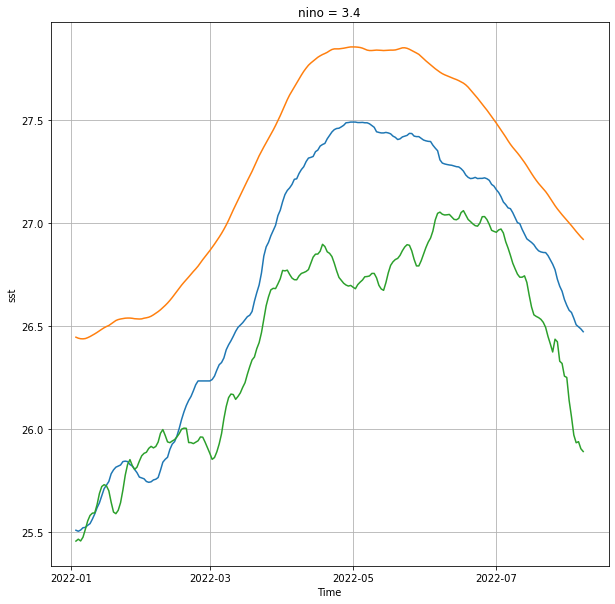

In [66]:
f, ax = plt.subplots(figsize=(10,10))
clim_repeat.sel(nino='3.4',quantile=0.25)['quantiles'].plot(ax=ax)
clim_repeat.sel(nino='3.4')['average'].plot(ax=ax)
dset.sel(nino='3.4')['sst'].plot(ax=ax)
ax.grid()

<xarray.Dataset>
Dimensions:    (nino: 5, time: 217)
Coordinates:
  * nino       (nino) object '1+2' '3' '4' '3.4' 'oni'
  * time       (time) object 2022-01-03 00:00:00 ... 2022-08-07 00:00:00
    dayofyear  (time) int64 3 4 5 6 7 8 9 10 ... 212 213 214 215 216 217 218 219
Data variables:
    sst        (nino, time) float32 dask.array<chunksize=(5, 217), meta=np.ndarray>

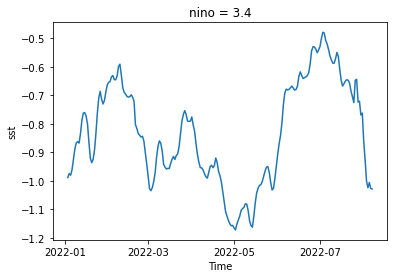

In [32]:
anoms.sel(nino='3.4')['sst'].plot()

In [35]:
ess = clim['quantiles'] - clim['average']

In [36]:
ess

<xarray.DataArray (dayofyear: 365, quantile: 5, nino: 5)>
dask.array<sub, shape=(365, 5, 5), dtype=float64, chunksize=(365, 5, 5), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * nino       (nino) object '1+2' '3' '4' '3.4' 'oni'
  * quantile   (quantile) float64 0.1 0.25 0.5 0.75 0.9

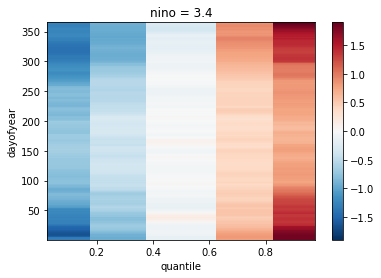

In [37]:
ess.sel(nino='3.4').plot()

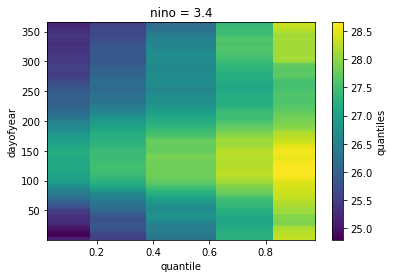

In [42]:
clim['quantiles'].sel(nino='3.4').plot()

In [56]:
ess_repeat = ess.sel(dayofyear=anoms.time.dt.dayofyear)

In [58]:
ess_repeat

<xarray.DataArray (time: 217, quantile: 5, nino: 5)>
dask.array<getitem, shape=(217, 5, 5), dtype=float64, chunksize=(217, 5, 5), chunktype=numpy.ndarray>
Coordinates:
    dayofyear  (time) int64 3 4 5 6 7 8 9 10 ... 212 213 214 215 216 217 218 219
  * nino       (nino) object '1+2' '3' '4' '3.4' 'oni'
  * quantile   (quantile) float64 0.1 0.25 0.5 0.75 0.9
  * time       (time) object 2022-01-03 00:00:00 ... 2022-08-07 00:00:00

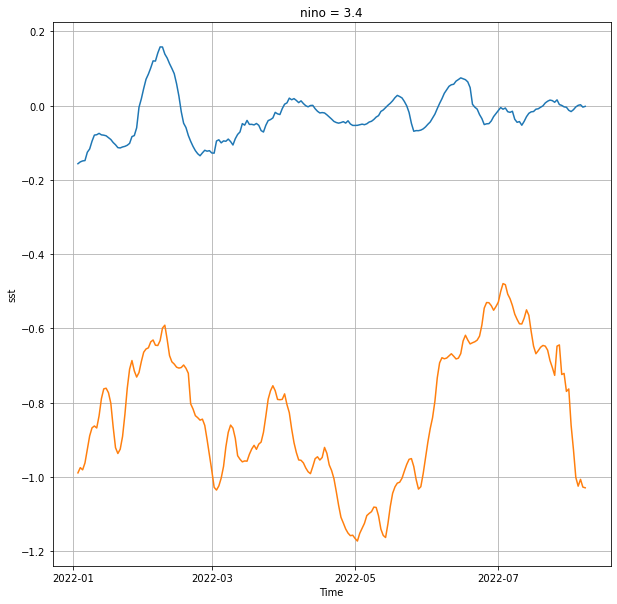

In [62]:
f, ax = plt.subplots(figsize=(10,10))
ess_repeat.sel(nino='3.4', quantile=0.5).plot(ax=ax)
anoms.sel(nino='3.4')['sst'].plot(ax=ax)
ax.grid()